This jupyter-notebook has be created with 'jupytext'.

Use this [Link](https://colab.research.google.com/github/magnumnp/magnumnp_demos/blob/main/rkky_biquadratic1.ipynb) to directly open the Notebook in Google Colab.

## Install magnum.np and fetch reference data (required for Colab)

In [1]:
!pip install -q triton magnumnp
from os import path
if not path.isdir("ref"):
    !mkdir ref
    !wget -P ref https://gitlab.com/magnum.np/magnum.np/raw/main/demos/rkky_biquadratic1/ref/m.dat &> /dev/null


#  Biquadratic Coupling Demo 1
 Example taken from Ubermag
 https://ubermag.github.io/examples/notebooks/rkky.html
But I reduced the M_sat of a layer by a half to better demonstrate the effect of the exchange coupling.
Implemented by Jed Cheng (jed.chengXmag.ed.kyushu-u.ac.jp, replace X with @)

## Run Simulation

In [2]:
from magnumnp import *
import torch
import numpy as np
import pathlib
from tqdm import tqdm

set_log_level(25) # show info_green, but hide info_blue
torch.set_default_dtype(torch.float32)

Timer.enable()
try:
    this_dir = pathlib.Path(__file__).resolve().parent
except:
    this_dir = pathlib.Path().resolve()


for sigma2 in np.array([0, -0.20, -0.10, -0.02]):
    J_rkky = sigma2

    # initialize mesh
    dt = 1e-10
    n  = (20, 20, 5)
    dx = (3e-9, 3e-9, 2e-9)
    mesh = Mesh(n, dx)
    state = State(mesh)

    state.material = {"alpha": 1}

    domain1 = state.Constant(False, dtype=torch.bool)
    domain2 = state.Constant(False, dtype=torch.bool)
    domain1[:,:,0:2] = True
    domain2[:,:,3:5] = True

    # Set initial magnetization
    state.m = state.Constant([0, 0, 0])
    size_ref = state.m[domain1].shape
    state.m[domain1] = torch.tensor([-0.99, 0.01, 0])
    state.m[domain2] = torch.tensor([0.99, 0.01, 0])

    Ku = state.Constant([0.0])
    Ku[domain1] = 1e5
    Ku[domain2] = 1e5

    A = state.Constant([0.0])
    A[domain1] = 1e-12
    A[domain2] = 1e-12

    Ms = state.Constant([0.0])
    Ms[domain1] = 8e6
    Ms[domain2] = 4e6

    Ku_axis = state.Constant([1, 0, 0])
    Ku_axis[domain1] = torch.tensor([1., 0., 0.])
    Ku_axis[domain2] = torch.tensor([1., 0., 0.])

    state.material['Ms'] = Ms
    state.material['A'] = A
    state.material['Ku'] = Ku
    state.material['Ku_axis'] = Ku_axis

    exchange1 = ExchangeField(domain1)
    exchange2 = ExchangeField(domain2)
    rkky      = BiquadraticRKKYField(float(J_rkky), "z", 1, 3)
    aniso     = UniaxialAnisotropyField()
    demag     = DemagField()

    llg = LLGSolver([demag, exchange1, exchange2, aniso, rkky])
    llg.relax(state)

    external = ExternalField(TimeInterpolator(state, 
                            {0.0e-9: [0.0, 0.0, 0.0],
                             1.0e-9: [0.0, 0.0, 0.0],
                             3.5e-9: [0, 0.0, 20/constants.mu_0],
                             8.5e-9: [0, 0.0, -20/constants.mu_0],
                             13.5e-9: [0, 0.0, 20/constants.mu_0]}))

    llg = LLGSolver([demag, aniso, exchange1, exchange2, external, rkky])
    m1 = ("m1", lambda state: state.m[domain1])
    m2 = ("m2", lambda state: state.m[domain2])
    logger = ScalarLogger(f"data/m_sigma2_{sigma2}.dat", ['t', external.h, 'm', m1, m2])

    for i in tqdm(torch.arange(0, 13.5e-9, dt)):
        llg.step(state, dt)
        logger << state

Timer.print_report()

2026-02-24 10:12:30  magnum.np:INFO magnum.np 2.2.0 (/usr/local/lib/python3.10/site-packages/ipykernel_launcher.py -f /tmp/tmpavx9jgr8.json --HistoryManager.hist_file=:memory:)


2026-02-24 10:12:30  magnum.np:INFO [State] running on device: cpu (dtype = float32)


2026-02-24 10:12:30  magnum.np:INFO [Mesh] 20x20x5 (dx= 3e-09 x 3e-09 x 2e-09)


2026-02-24 10:12:30  magnum.np:INFO [LLGSolver] using RKF45 solver (atol = 1e-05)


2026-02-24 10:13:23  magnum.np:INFO [LLG] relax: Successfully converged (iter=474, dm_tol = 100)


2026-02-24 10:13:23  magnum.np:INFO [LLGSolver] using RKF45 solver (atol = 1e-05)


  0%|          | 0/135 [00:00<?, ?it/s]

  1%|          | 1/135 [00:00<01:45,  1.27it/s]

  1%|▏         | 2/135 [00:01<01:41,  1.31it/s]

  2%|▏         | 3/135 [00:02<01:41,  1.30it/s]

  3%|▎         | 4/135 [00:03<01:40,  1.31it/s]

  4%|▎         | 5/135 [00:03<01:41,  1.28it/s]

  4%|▍         | 6/135 [00:04<01:39,  1.29it/s]

  5%|▌         | 7/135 [00:05<01:38,  1.31it/s]

  6%|▌         | 8/135 [00:06<01:35,  1.32it/s]

  7%|▋         | 9/135 [00:06<01:36,  1.30it/s]

  7%|▋         | 10/135 [00:07<01:37,  1.28it/s]

  8%|▊         | 11/135 [00:08<01:36,  1.28it/s]

  9%|▉         | 12/135 [00:09<01:33,  1.31it/s]

 10%|▉         | 13/135 [00:09<01:29,  1.37it/s]

 10%|█         | 14/135 [00:10<01:27,  1.38it/s]

 11%|█         | 15/135 [00:11<01:23,  1.44it/s]

 12%|█▏        | 16/135 [00:12<01:29,  1.33it/s]

 13%|█▎        | 17/135 [00:12<01:31,  1.29it/s]

 13%|█▎        | 18/135 [00:13<01:25,  1.36it/s]

 14%|█▍        | 19/135 [00:14<01:22,  1.40it/s]

 15%|█▍        | 20/135 [00:14<01:21,  1.41it/s]

 16%|█▌        | 21/135 [00:15<01:25,  1.33it/s]

 16%|█▋        | 22/135 [00:16<01:31,  1.24it/s]

 17%|█▋        | 23/135 [00:17<01:37,  1.15it/s]

 18%|█▊        | 24/135 [00:18<01:45,  1.06it/s]

 19%|█▊        | 25/135 [00:20<01:52,  1.02s/it]

 19%|█▉        | 26/135 [00:21<02:00,  1.11s/it]

 20%|██        | 27/135 [00:22<02:07,  1.18s/it]

 21%|██        | 28/135 [00:24<02:16,  1.27s/it]

 21%|██▏       | 29/135 [00:25<02:21,  1.34s/it]

 22%|██▏       | 30/135 [00:27<02:28,  1.42s/it]

 23%|██▎       | 31/135 [00:28<02:34,  1.49s/it]

 24%|██▎       | 32/135 [00:30<02:41,  1.56s/it]

 24%|██▍       | 33/135 [00:32<02:47,  1.64s/it]

 25%|██▌       | 34/135 [00:34<02:53,  1.72s/it]

 26%|██▌       | 35/135 [00:36<03:00,  1.81s/it]

 27%|██▋       | 36/135 [00:38<03:05,  1.88s/it]

 27%|██▋       | 37/135 [00:40<03:06,  1.90s/it]

 28%|██▊       | 38/135 [00:42<03:01,  1.87s/it]

 29%|██▉       | 39/135 [00:43<02:54,  1.82s/it]

 30%|██▉       | 40/135 [00:45<02:49,  1.78s/it]

 30%|███       | 41/135 [00:47<02:42,  1.73s/it]

 31%|███       | 42/135 [00:48<02:35,  1.67s/it]

 32%|███▏      | 43/135 [00:50<02:27,  1.60s/it]

 33%|███▎      | 44/135 [00:51<02:16,  1.50s/it]

 33%|███▎      | 45/135 [00:52<02:07,  1.42s/it]

 34%|███▍      | 46/135 [00:53<01:59,  1.34s/it]

 35%|███▍      | 47/135 [00:55<01:52,  1.28s/it]

 36%|███▌      | 48/135 [00:56<01:44,  1.20s/it]

 36%|███▋      | 49/135 [00:56<01:35,  1.11s/it]

 37%|███▋      | 50/135 [00:57<01:28,  1.04s/it]

 38%|███▊      | 51/135 [00:58<01:19,  1.05it/s]

 39%|███▊      | 52/135 [00:59<01:12,  1.15it/s]

 39%|███▉      | 53/135 [00:59<01:03,  1.30it/s]

 40%|████      | 54/135 [01:00<00:58,  1.37it/s]

 41%|████      | 55/135 [01:01<00:56,  1.41it/s]

 41%|████▏     | 56/135 [01:01<00:54,  1.44it/s]

 42%|████▏     | 57/135 [01:02<00:53,  1.46it/s]

 43%|████▎     | 58/135 [01:03<00:51,  1.49it/s]

 44%|████▎     | 59/135 [01:03<00:54,  1.38it/s]

 44%|████▍     | 60/135 [01:04<00:52,  1.42it/s]

 45%|████▌     | 61/135 [01:05<00:53,  1.39it/s]

 46%|████▌     | 62/135 [01:06<00:54,  1.33it/s]

 47%|████▋     | 63/135 [01:06<00:52,  1.37it/s]

 47%|████▋     | 64/135 [01:07<00:51,  1.37it/s]

 48%|████▊     | 65/135 [01:08<00:49,  1.42it/s]

 49%|████▉     | 66/135 [01:08<00:47,  1.46it/s]

 50%|████▉     | 67/135 [01:09<00:43,  1.55it/s]

 50%|█████     | 68/135 [01:09<00:40,  1.65it/s]

 51%|█████     | 69/135 [01:10<00:42,  1.55it/s]

 52%|█████▏    | 70/135 [01:11<00:44,  1.48it/s]

 53%|█████▎    | 71/135 [01:12<00:47,  1.36it/s]

 53%|█████▎    | 72/135 [01:13<00:50,  1.24it/s]

 54%|█████▍    | 73/135 [01:14<00:54,  1.14it/s]

 55%|█████▍    | 74/135 [01:15<00:57,  1.05it/s]

 56%|█████▌    | 75/135 [01:16<01:00,  1.01s/it]

 56%|█████▋    | 76/135 [01:17<01:03,  1.08s/it]

 57%|█████▋    | 77/135 [01:18<01:05,  1.13s/it]

 58%|█████▊    | 78/135 [01:20<01:08,  1.21s/it]

 59%|█████▊    | 79/135 [01:21<01:12,  1.30s/it]

 59%|█████▉    | 80/135 [01:23<01:16,  1.39s/it]

 60%|██████    | 81/135 [01:25<01:19,  1.46s/it]

 61%|██████    | 82/135 [01:26<01:22,  1.56s/it]

 61%|██████▏   | 83/135 [01:28<01:24,  1.63s/it]

 62%|██████▏   | 84/135 [01:30<01:26,  1.70s/it]

 63%|██████▎   | 85/135 [01:32<01:29,  1.80s/it]

 64%|██████▎   | 86/135 [01:34<01:30,  1.86s/it]

 64%|██████▍   | 87/135 [01:36<01:29,  1.87s/it]

 65%|██████▌   | 88/135 [01:38<01:27,  1.85s/it]

 66%|██████▌   | 89/135 [01:40<01:24,  1.83s/it]

 67%|██████▋   | 90/135 [01:41<01:20,  1.79s/it]

 67%|██████▋   | 91/135 [01:43<01:16,  1.73s/it]

 68%|██████▊   | 92/135 [01:44<01:11,  1.66s/it]

 69%|██████▉   | 93/135 [01:46<01:07,  1.60s/it]

 70%|██████▉   | 94/135 [01:47<01:03,  1.54s/it]

 70%|███████   | 95/135 [01:49<00:58,  1.46s/it]

 71%|███████   | 96/135 [01:50<00:53,  1.37s/it]

 72%|███████▏  | 97/135 [01:51<00:47,  1.25s/it]

 73%|███████▎  | 98/135 [01:52<00:43,  1.18s/it]

 73%|███████▎  | 99/135 [01:52<00:37,  1.05s/it]

 74%|███████▍  | 100/135 [01:53<00:34,  1.02it/s]

 75%|███████▍  | 101/135 [01:54<00:31,  1.09it/s]

 76%|███████▌  | 102/135 [01:55<00:27,  1.19it/s]

 76%|███████▋  | 103/135 [01:55<00:24,  1.33it/s]

 77%|███████▋  | 104/135 [01:56<00:21,  1.42it/s]

 78%|███████▊  | 105/135 [01:56<00:20,  1.47it/s]

 79%|███████▊  | 106/135 [01:57<00:19,  1.48it/s]

 79%|███████▉  | 107/135 [01:58<00:18,  1.53it/s]

 80%|████████  | 108/135 [01:58<00:18,  1.49it/s]

 81%|████████  | 109/135 [01:59<00:18,  1.42it/s]

 81%|████████▏ | 110/135 [02:00<00:17,  1.45it/s]

 82%|████████▏ | 111/135 [02:01<00:16,  1.43it/s]

 83%|████████▎ | 112/135 [02:01<00:17,  1.33it/s]

 84%|████████▎ | 113/135 [02:02<00:16,  1.35it/s]

 84%|████████▍ | 114/135 [02:03<00:14,  1.41it/s]

 85%|████████▌ | 115/135 [02:03<00:13,  1.49it/s]

 86%|████████▌ | 116/135 [02:04<00:12,  1.54it/s]

 87%|████████▋ | 117/135 [02:04<00:11,  1.62it/s]

 87%|████████▋ | 118/135 [02:05<00:10,  1.70it/s]

 88%|████████▊ | 119/135 [02:06<00:09,  1.63it/s]

 89%|████████▉ | 120/135 [02:06<00:09,  1.56it/s]

 90%|████████▉ | 121/135 [02:07<00:09,  1.41it/s]

 90%|█████████ | 122/135 [02:08<00:10,  1.29it/s]

 91%|█████████ | 123/135 [02:09<00:10,  1.18it/s]

 92%|█████████▏| 124/135 [02:10<00:10,  1.09it/s]

 93%|█████████▎| 125/135 [02:12<00:10,  1.01s/it]

 93%|█████████▎| 126/135 [02:13<00:09,  1.10s/it]

 94%|█████████▍| 127/135 [02:14<00:09,  1.19s/it]

 95%|█████████▍| 128/135 [02:16<00:08,  1.26s/it]

 96%|█████████▌| 129/135 [02:17<00:07,  1.33s/it]

 96%|█████████▋| 130/135 [02:19<00:06,  1.40s/it]

 97%|█████████▋| 131/135 [02:20<00:05,  1.45s/it]

 98%|█████████▊| 132/135 [02:22<00:04,  1.53s/it]

 99%|█████████▊| 133/135 [02:24<00:03,  1.61s/it]

 99%|█████████▉| 134/135 [02:26<00:01,  1.68s/it]

100%|██████████| 135/135 [02:28<00:00,  1.78s/it]

100%|██████████| 135/135 [02:28<00:00,  1.10s/it]


2026-02-24 10:15:51  magnum.np:INFO [State] running on device: cpu (dtype = float32)


2026-02-24 10:15:51  magnum.np:INFO [Mesh] 20x20x5 (dx= 3e-09 x 3e-09 x 2e-09)


2026-02-24 10:15:51  magnum.np:INFO [LLGSolver] using RKF45 solver (atol = 1e-05)


2026-02-24 10:17:46  magnum.np:INFO [LLG] relax: Successfully converged (iter=230, dm_tol = 100)


2026-02-24 10:17:46  magnum.np:INFO [LLGSolver] using RKF45 solver (atol = 1e-05)


  0%|          | 0/135 [00:00<?, ?it/s]

  1%|          | 1/135 [00:04<10:38,  4.76s/it]

  1%|▏         | 2/135 [00:09<10:56,  4.94s/it]

  2%|▏         | 3/135 [00:14<10:57,  4.98s/it]

  3%|▎         | 4/135 [00:19<10:56,  5.01s/it]

  4%|▎         | 5/135 [00:24<10:48,  4.99s/it]

  4%|▍         | 6/135 [00:29<10:45,  5.00s/it]

  5%|▌         | 7/135 [00:34<10:42,  5.02s/it]

  6%|▌         | 8/135 [00:39<10:35,  5.00s/it]

  7%|▋         | 9/135 [00:44<10:25,  4.97s/it]

  7%|▋         | 10/135 [00:49<10:20,  4.96s/it]

  8%|▊         | 11/135 [00:54<10:13,  4.95s/it]

  9%|▉         | 12/135 [00:59<10:16,  5.01s/it]

 10%|▉         | 13/135 [01:04<09:52,  4.86s/it]

 10%|█         | 14/135 [01:09<09:54,  4.91s/it]

 11%|█         | 15/135 [01:14<10:03,  5.03s/it]

 12%|█▏        | 16/135 [01:19<09:57,  5.02s/it]

 13%|█▎        | 17/135 [01:24<09:43,  4.95s/it]

 13%|█▎        | 18/135 [01:29<09:43,  4.99s/it]

 14%|█▍        | 19/135 [01:34<09:44,  5.04s/it]

 15%|█▍        | 20/135 [01:39<09:44,  5.08s/it]

 16%|█▌        | 21/135 [01:44<09:40,  5.09s/it]

 16%|█▋        | 22/135 [01:50<09:39,  5.12s/it]

 17%|█▋        | 23/135 [01:55<09:36,  5.15s/it]

 18%|█▊        | 24/135 [02:00<09:31,  5.14s/it]

 19%|█▊        | 25/135 [02:05<09:28,  5.17s/it]

 19%|█▉        | 26/135 [02:11<09:26,  5.20s/it]

 20%|██        | 27/135 [02:16<09:23,  5.22s/it]

 21%|██        | 28/135 [02:21<09:20,  5.24s/it]

 21%|██▏       | 29/135 [02:26<09:14,  5.23s/it]

 22%|██▏       | 30/135 [02:31<09:04,  5.19s/it]

 23%|██▎       | 31/135 [02:37<09:00,  5.20s/it]

 24%|██▎       | 32/135 [02:42<08:54,  5.19s/it]

 24%|██▍       | 33/135 [02:47<08:47,  5.17s/it]

 25%|██▌       | 34/135 [02:52<08:40,  5.16s/it]

 26%|██▌       | 35/135 [02:57<08:35,  5.15s/it]

 27%|██▋       | 36/135 [03:02<08:30,  5.15s/it]

 27%|██▋       | 37/135 [03:07<08:21,  5.12s/it]

 28%|██▊       | 38/135 [03:13<08:20,  5.16s/it]

 29%|██▉       | 39/135 [03:18<08:20,  5.21s/it]

 30%|██▉       | 40/135 [03:23<08:24,  5.31s/it]

 30%|███       | 41/135 [03:29<08:20,  5.32s/it]

 31%|███       | 42/135 [03:34<08:15,  5.33s/it]

 32%|███▏      | 43/135 [03:39<08:07,  5.30s/it]

 33%|███▎      | 44/135 [03:45<08:01,  5.30s/it]

 33%|███▎      | 45/135 [03:50<07:54,  5.27s/it]

 34%|███▍      | 46/135 [03:55<07:46,  5.24s/it]

 35%|███▍      | 47/135 [04:00<07:40,  5.24s/it]

 36%|███▌      | 48/135 [04:05<07:34,  5.22s/it]

 36%|███▋      | 49/135 [04:11<07:29,  5.22s/it]

 37%|███▋      | 50/135 [04:16<07:25,  5.24s/it]

 38%|███▊      | 51/135 [04:21<07:20,  5.24s/it]

 39%|███▊      | 52/135 [04:26<07:12,  5.21s/it]

 39%|███▉      | 53/135 [04:31<07:04,  5.17s/it]

 40%|████      | 54/135 [04:37<06:56,  5.14s/it]

 41%|████      | 55/135 [04:42<06:48,  5.11s/it]

 41%|████▏     | 56/135 [04:47<06:45,  5.13s/it]

 42%|████▏     | 57/135 [04:52<06:40,  5.13s/it]

 43%|████▎     | 58/135 [04:57<06:27,  5.03s/it]

 44%|████▎     | 59/135 [05:02<06:20,  5.01s/it]

 44%|████▍     | 60/135 [05:07<06:14,  4.99s/it]

 45%|████▌     | 61/135 [05:11<06:07,  4.97s/it]

 46%|████▌     | 62/135 [05:16<06:00,  4.93s/it]

 47%|████▋     | 63/135 [05:21<05:46,  4.81s/it]

 47%|████▋     | 64/135 [05:26<05:39,  4.78s/it]

 48%|████▊     | 65/135 [05:31<05:42,  4.89s/it]

 49%|████▉     | 66/135 [05:36<05:42,  4.96s/it]

 50%|████▉     | 67/135 [05:41<05:43,  5.05s/it]

 50%|█████     | 68/135 [05:46<05:39,  5.06s/it]

 51%|█████     | 69/135 [05:51<05:33,  5.05s/it]

 52%|█████▏    | 70/135 [05:56<05:28,  5.05s/it]

 53%|█████▎    | 71/135 [06:01<05:26,  5.10s/it]

 53%|█████▎    | 72/135 [06:07<05:20,  5.09s/it]

 54%|█████▍    | 73/135 [06:12<05:16,  5.11s/it]

 55%|█████▍    | 74/135 [06:17<05:12,  5.12s/it]

 56%|█████▌    | 75/135 [06:22<05:07,  5.12s/it]

 56%|█████▋    | 76/135 [06:27<05:03,  5.14s/it]

 57%|█████▋    | 77/135 [06:32<04:58,  5.14s/it]

 58%|█████▊    | 78/135 [06:38<04:54,  5.16s/it]

 59%|█████▊    | 79/135 [06:43<04:48,  5.15s/it]

 59%|█████▉    | 80/135 [06:48<04:41,  5.12s/it]

 60%|██████    | 81/135 [06:53<04:37,  5.14s/it]

 61%|██████    | 82/135 [06:58<04:34,  5.17s/it]

 61%|██████▏   | 83/135 [07:03<04:28,  5.17s/it]

 62%|██████▏   | 84/135 [07:08<04:23,  5.16s/it]

 63%|██████▎   | 85/135 [07:14<04:17,  5.14s/it]

 64%|██████▎   | 86/135 [07:19<04:12,  5.16s/it]

 64%|██████▍   | 87/135 [07:24<04:08,  5.17s/it]

 65%|██████▌   | 88/135 [07:29<04:01,  5.13s/it]

 66%|██████▌   | 89/135 [07:34<03:56,  5.15s/it]

 67%|██████▋   | 90/135 [07:39<03:52,  5.17s/it]

 67%|██████▋   | 91/135 [07:44<03:46,  5.15s/it]

 68%|██████▊   | 92/135 [07:50<03:42,  5.18s/it]

 69%|██████▉   | 93/135 [07:55<03:37,  5.17s/it]

 70%|██████▉   | 94/135 [08:00<03:33,  5.22s/it]

 70%|███████   | 95/135 [08:05<03:28,  5.21s/it]

 71%|███████   | 96/135 [08:11<03:22,  5.19s/it]

 72%|███████▏  | 97/135 [08:16<03:15,  5.16s/it]

 73%|███████▎  | 98/135 [08:21<03:11,  5.18s/it]

 73%|███████▎  | 99/135 [08:26<03:04,  5.13s/it]

 74%|███████▍  | 100/135 [08:31<02:59,  5.14s/it]

 75%|███████▍  | 101/135 [08:36<02:54,  5.12s/it]

 76%|███████▌  | 102/135 [08:41<02:49,  5.15s/it]

 76%|███████▋  | 103/135 [08:46<02:41,  5.06s/it]

 77%|███████▋  | 104/135 [08:51<02:36,  5.05s/it]

 78%|███████▊  | 105/135 [08:56<02:32,  5.08s/it]

 79%|███████▊  | 106/135 [09:01<02:27,  5.08s/it]

 79%|███████▉  | 107/135 [09:06<02:20,  5.03s/it]

 80%|████████  | 108/135 [09:11<02:12,  4.92s/it]

 81%|████████  | 109/135 [09:16<02:09,  4.97s/it]

 81%|████████▏ | 110/135 [09:21<02:03,  4.93s/it]

 82%|████████▏ | 111/135 [09:26<01:58,  4.95s/it]

 83%|████████▎ | 112/135 [09:31<01:53,  4.95s/it]

 84%|████████▎ | 113/135 [09:36<01:49,  4.96s/it]

 84%|████████▍ | 114/135 [09:41<01:44,  4.96s/it]

 85%|████████▌ | 115/135 [09:46<01:40,  5.02s/it]

 86%|████████▌ | 116/135 [09:51<01:36,  5.06s/it]

 87%|████████▋ | 117/135 [09:56<01:31,  5.07s/it]

 87%|████████▋ | 118/135 [10:01<01:26,  5.06s/it]

 88%|████████▊ | 119/135 [10:06<01:21,  5.10s/it]

 89%|████████▉ | 120/135 [10:12<01:16,  5.13s/it]

 90%|████████▉ | 121/135 [10:17<01:11,  5.08s/it]

 90%|█████████ | 122/135 [10:22<01:06,  5.13s/it]

 91%|█████████ | 123/135 [10:27<01:01,  5.15s/it]

 92%|█████████▏| 124/135 [10:32<00:56,  5.15s/it]

 93%|█████████▎| 125/135 [10:37<00:51,  5.16s/it]

 93%|█████████▎| 126/135 [10:42<00:46,  5.12s/it]

 94%|█████████▍| 127/135 [10:48<00:41,  5.14s/it]

 95%|█████████▍| 128/135 [10:53<00:36,  5.16s/it]

 96%|█████████▌| 129/135 [10:58<00:30,  5.16s/it]

 96%|█████████▋| 130/135 [11:03<00:25,  5.12s/it]

 97%|█████████▋| 131/135 [11:08<00:20,  5.13s/it]

 98%|█████████▊| 132/135 [11:13<00:15,  5.09s/it]

 99%|█████████▊| 133/135 [11:18<00:10,  5.09s/it]

 99%|█████████▉| 134/135 [11:23<00:05,  5.09s/it]

100%|██████████| 135/135 [11:28<00:00,  5.09s/it]

100%|██████████| 135/135 [11:28<00:00,  5.10s/it]


2026-02-24 10:29:15  magnum.np:INFO [State] running on device: cpu (dtype = float32)


2026-02-24 10:29:15  magnum.np:INFO [Mesh] 20x20x5 (dx= 3e-09 x 3e-09 x 2e-09)


2026-02-24 10:29:15  magnum.np:INFO [LLGSolver] using RKF45 solver (atol = 1e-05)


2026-02-24 10:30:22  magnum.np:INFO [LLG] relax: Successfully converged (iter=241, dm_tol = 100)


2026-02-24 10:30:22  magnum.np:INFO [LLGSolver] using RKF45 solver (atol = 1e-05)


  0%|          | 0/135 [00:00<?, ?it/s]

  1%|          | 1/135 [00:02<05:30,  2.46s/it]

  1%|▏         | 2/135 [00:04<05:31,  2.50s/it]

  2%|▏         | 3/135 [00:07<05:34,  2.53s/it]

  3%|▎         | 4/135 [00:10<05:33,  2.55s/it]

  4%|▎         | 5/135 [00:12<05:30,  2.54s/it]

  4%|▍         | 6/135 [00:15<05:30,  2.56s/it]

  5%|▌         | 7/135 [00:17<05:28,  2.56s/it]

  6%|▌         | 8/135 [00:20<05:22,  2.54s/it]

  7%|▋         | 9/135 [00:22<05:14,  2.50s/it]

  7%|▋         | 10/135 [00:25<05:11,  2.49s/it]

  8%|▊         | 11/135 [00:27<05:07,  2.48s/it]

  9%|▉         | 12/135 [00:30<05:01,  2.45s/it]

 10%|▉         | 13/135 [00:32<05:05,  2.50s/it]

 10%|█         | 14/135 [00:34<04:54,  2.43s/it]

 11%|█         | 15/135 [00:37<04:52,  2.44s/it]

 12%|█▏        | 16/135 [00:39<04:47,  2.42s/it]

 13%|█▎        | 17/135 [00:42<04:45,  2.42s/it]

 13%|█▎        | 18/135 [00:44<04:51,  2.49s/it]

 14%|█▍        | 19/135 [00:47<04:51,  2.51s/it]

 15%|█▍        | 20/135 [00:50<04:57,  2.59s/it]

 16%|█▌        | 21/135 [00:52<04:59,  2.63s/it]

 16%|█▋        | 22/135 [00:55<04:57,  2.63s/it]

 17%|█▋        | 23/135 [00:58<05:05,  2.72s/it]

 18%|█▊        | 24/135 [01:01<05:00,  2.71s/it]

 19%|█▊        | 25/135 [01:03<04:58,  2.72s/it]

 19%|█▉        | 26/135 [01:06<04:54,  2.71s/it]

 20%|██        | 27/135 [01:09<04:49,  2.68s/it]

 21%|██        | 28/135 [01:11<04:47,  2.69s/it]

 21%|██▏       | 29/135 [01:14<04:44,  2.68s/it]

 22%|██▏       | 30/135 [01:17<04:41,  2.68s/it]

 23%|██▎       | 31/135 [01:19<04:30,  2.60s/it]

 24%|██▎       | 32/135 [01:22<04:22,  2.55s/it]

 24%|██▍       | 33/135 [01:24<04:08,  2.44s/it]

 25%|██▌       | 34/135 [01:26<04:01,  2.39s/it]

 26%|██▌       | 35/135 [01:28<03:55,  2.36s/it]

 27%|██▋       | 36/135 [01:31<03:56,  2.39s/it]

 27%|██▋       | 37/135 [01:33<03:53,  2.39s/it]

 28%|██▊       | 38/135 [01:36<03:52,  2.40s/it]

 29%|██▉       | 39/135 [01:38<03:51,  2.41s/it]

 30%|██▉       | 40/135 [01:41<03:53,  2.46s/it]

 30%|███       | 41/135 [01:43<03:51,  2.46s/it]

 31%|███       | 42/135 [01:46<03:54,  2.52s/it]

 32%|███▏      | 43/135 [01:49<04:07,  2.69s/it]

 33%|███▎      | 44/135 [01:51<04:03,  2.68s/it]

 33%|███▎      | 45/135 [01:54<03:59,  2.66s/it]

 34%|███▍      | 46/135 [01:57<03:55,  2.65s/it]

 35%|███▍      | 47/135 [01:59<03:56,  2.68s/it]

 36%|███▌      | 48/135 [02:02<03:54,  2.69s/it]

 36%|███▋      | 49/135 [02:05<03:50,  2.68s/it]

 37%|███▋      | 50/135 [02:08<03:49,  2.70s/it]

 38%|███▊      | 51/135 [02:10<03:47,  2.71s/it]

 39%|███▊      | 52/135 [02:13<03:43,  2.70s/it]

 39%|███▉      | 53/135 [02:16<03:41,  2.70s/it]

 40%|████      | 54/135 [02:18<03:39,  2.72s/it]

 41%|████      | 55/135 [02:21<03:35,  2.70s/it]

 41%|████▏     | 56/135 [02:24<03:33,  2.71s/it]

 42%|████▏     | 57/135 [02:26<03:24,  2.63s/it]

 43%|████▎     | 58/135 [02:29<03:21,  2.62s/it]

 44%|████▎     | 59/135 [02:32<03:25,  2.70s/it]

 44%|████▍     | 60/135 [02:34<03:17,  2.63s/it]

 45%|████▌     | 61/135 [02:37<03:11,  2.59s/it]

 46%|████▌     | 62/135 [02:39<03:10,  2.61s/it]

 47%|████▋     | 63/135 [02:42<03:05,  2.58s/it]

 47%|████▋     | 64/135 [02:44<03:02,  2.57s/it]

 48%|████▊     | 65/135 [02:47<02:57,  2.53s/it]

 49%|████▉     | 66/135 [02:50<02:57,  2.58s/it]

 50%|████▉     | 67/135 [02:52<02:56,  2.59s/it]

 50%|█████     | 68/135 [02:55<02:53,  2.59s/it]

 51%|█████     | 69/135 [02:57<02:53,  2.62s/it]

 52%|█████▏    | 70/135 [03:00<02:53,  2.67s/it]

 53%|█████▎    | 71/135 [03:03<02:52,  2.70s/it]

 53%|█████▎    | 72/135 [03:06<02:50,  2.71s/it]

 54%|█████▍    | 73/135 [03:08<02:46,  2.68s/it]

 55%|█████▍    | 74/135 [03:11<02:42,  2.67s/it]

 56%|█████▌    | 75/135 [03:14<02:39,  2.66s/it]

 56%|█████▋    | 76/135 [03:16<02:36,  2.65s/it]

 57%|█████▋    | 77/135 [03:19<02:31,  2.61s/it]

 58%|█████▊    | 78/135 [03:21<02:27,  2.59s/it]

 59%|█████▊    | 79/135 [03:24<02:23,  2.57s/it]

 59%|█████▉    | 80/135 [03:26<02:21,  2.57s/it]

 60%|██████    | 81/135 [03:29<02:16,  2.53s/it]

 61%|██████    | 82/135 [03:31<02:13,  2.52s/it]

 61%|██████▏   | 83/135 [03:34<02:10,  2.51s/it]

 62%|██████▏   | 84/135 [03:36<02:07,  2.50s/it]

 63%|██████▎   | 85/135 [03:39<02:03,  2.47s/it]

 64%|██████▎   | 86/135 [03:41<01:59,  2.44s/it]

 64%|██████▍   | 87/135 [03:44<01:58,  2.47s/it]

 65%|██████▌   | 88/135 [03:46<01:55,  2.45s/it]

 66%|██████▌   | 89/135 [03:49<01:53,  2.46s/it]

 67%|██████▋   | 90/135 [03:51<01:51,  2.48s/it]

 67%|██████▋   | 91/135 [03:54<01:49,  2.48s/it]

 68%|██████▊   | 92/135 [03:56<01:47,  2.49s/it]

 69%|██████▉   | 93/135 [03:59<01:46,  2.53s/it]

 70%|██████▉   | 94/135 [04:01<01:44,  2.56s/it]

 70%|███████   | 95/135 [04:04<01:43,  2.58s/it]

 71%|███████   | 96/135 [04:07<01:42,  2.63s/it]

 72%|███████▏  | 97/135 [04:09<01:40,  2.64s/it]

 73%|███████▎  | 98/135 [04:12<01:37,  2.65s/it]

 73%|███████▎  | 99/135 [04:15<01:35,  2.66s/it]

 74%|███████▍  | 100/135 [04:17<01:33,  2.66s/it]

 75%|███████▍  | 101/135 [04:20<01:29,  2.64s/it]

 76%|███████▌  | 102/135 [04:23<01:27,  2.65s/it]

 76%|███████▋  | 103/135 [04:25<01:25,  2.67s/it]

 77%|███████▋  | 104/135 [04:28<01:23,  2.69s/it]

 78%|███████▊  | 105/135 [04:31<01:20,  2.69s/it]

 79%|███████▊  | 106/135 [04:33<01:17,  2.67s/it]

 79%|███████▉  | 107/135 [04:36<01:13,  2.62s/it]

 80%|████████  | 108/135 [04:39<01:10,  2.63s/it]

 81%|████████  | 109/135 [04:41<01:04,  2.49s/it]

 81%|████████▏ | 110/135 [04:43<01:01,  2.46s/it]

 82%|████████▏ | 111/135 [04:45<00:58,  2.42s/it]

 83%|████████▎ | 112/135 [04:48<00:57,  2.51s/it]

 84%|████████▎ | 113/135 [04:50<00:54,  2.46s/it]

 84%|████████▍ | 114/135 [04:53<00:52,  2.51s/it]

 85%|████████▌ | 115/135 [04:56<00:49,  2.49s/it]

 86%|████████▌ | 116/135 [04:58<00:47,  2.51s/it]

 87%|████████▋ | 117/135 [05:01<00:45,  2.54s/it]

 87%|████████▋ | 118/135 [05:03<00:43,  2.55s/it]

 88%|████████▊ | 119/135 [05:06<00:41,  2.61s/it]

 89%|████████▉ | 120/135 [05:09<00:39,  2.65s/it]

 90%|████████▉ | 121/135 [05:11<00:37,  2.67s/it]

 90%|█████████ | 122/135 [05:14<00:34,  2.69s/it]

 91%|█████████ | 123/135 [05:17<00:32,  2.69s/it]

 92%|█████████▏| 124/135 [05:20<00:29,  2.67s/it]

 93%|█████████▎| 125/135 [05:22<00:26,  2.66s/it]

 93%|█████████▎| 126/135 [05:25<00:23,  2.64s/it]

 94%|█████████▍| 127/135 [05:27<00:21,  2.65s/it]

 95%|█████████▍| 128/135 [05:30<00:18,  2.65s/it]

 96%|█████████▌| 129/135 [05:33<00:15,  2.63s/it]

 96%|█████████▋| 130/135 [05:35<00:13,  2.61s/it]

 97%|█████████▋| 131/135 [05:38<00:10,  2.60s/it]

 98%|█████████▊| 132/135 [05:40<00:07,  2.60s/it]

 99%|█████████▊| 133/135 [05:43<00:05,  2.55s/it]

 99%|█████████▉| 134/135 [05:45<00:02,  2.54s/it]

100%|██████████| 135/135 [05:48<00:00,  2.49s/it]

100%|██████████| 135/135 [05:48<00:00,  2.58s/it]


2026-02-24 10:36:10  magnum.np:INFO [State] running on device: cpu (dtype = float32)


2026-02-24 10:36:10  magnum.np:INFO [Mesh] 20x20x5 (dx= 3e-09 x 3e-09 x 2e-09)


2026-02-24 10:36:10  magnum.np:INFO [LLGSolver] using RKF45 solver (atol = 1e-05)


2026-02-24 10:36:35  magnum.np:INFO [LLG] relax: Successfully converged (iter=216, dm_tol = 100)


2026-02-24 10:36:35  magnum.np:INFO [LLGSolver] using RKF45 solver (atol = 1e-05)


  0%|          | 0/135 [00:00<?, ?it/s]

  1%|          | 1/135 [00:00<02:07,  1.05it/s]

  1%|▏         | 2/135 [00:01<02:01,  1.10it/s]

  2%|▏         | 3/135 [00:02<02:01,  1.09it/s]

  3%|▎         | 4/135 [00:03<01:59,  1.10it/s]

  4%|▎         | 5/135 [00:04<01:59,  1.08it/s]

  4%|▍         | 6/135 [00:05<01:57,  1.09it/s]

  5%|▌         | 7/135 [00:06<01:55,  1.10it/s]

  6%|▌         | 8/135 [00:07<01:56,  1.09it/s]

  7%|▋         | 9/135 [00:08<01:54,  1.10it/s]

  7%|▋         | 10/135 [00:09<01:55,  1.08it/s]

  8%|▊         | 11/135 [00:10<01:52,  1.10it/s]

  9%|▉         | 12/135 [00:10<01:45,  1.17it/s]

 10%|▉         | 13/135 [00:11<01:46,  1.15it/s]

 10%|█         | 14/135 [00:12<01:53,  1.07it/s]

 11%|█         | 15/135 [00:13<01:56,  1.03it/s]

 12%|█▏        | 16/135 [00:14<02:01,  1.02s/it]

 13%|█▎        | 17/135 [00:15<01:55,  1.02it/s]

 13%|█▎        | 18/135 [00:16<01:51,  1.05it/s]

 14%|█▍        | 19/135 [00:17<01:53,  1.02it/s]

 15%|█▍        | 20/135 [00:18<01:52,  1.02it/s]

 16%|█▌        | 21/135 [00:19<01:42,  1.11it/s]

 16%|█▋        | 22/135 [00:20<01:41,  1.11it/s]

 17%|█▋        | 23/135 [00:21<01:43,  1.08it/s]

 18%|█▊        | 24/135 [00:22<01:44,  1.07it/s]

 19%|█▊        | 25/135 [00:23<01:50,  1.00s/it]

 19%|█▉        | 26/135 [00:24<01:55,  1.06s/it]

 20%|██        | 27/135 [00:25<02:02,  1.13s/it]

 21%|██        | 28/135 [00:27<02:08,  1.20s/it]

 21%|██▏       | 29/135 [00:28<02:15,  1.28s/it]

 22%|██▏       | 30/135 [00:30<02:24,  1.37s/it]

 23%|██▎       | 31/135 [00:32<02:30,  1.45s/it]

 24%|██▎       | 32/135 [00:33<02:39,  1.54s/it]

 24%|██▍       | 33/135 [00:35<02:45,  1.62s/it]

 25%|██▌       | 34/135 [00:37<02:51,  1.69s/it]

 26%|██▌       | 35/135 [00:39<02:55,  1.76s/it]

 27%|██▋       | 36/135 [00:41<03:00,  1.82s/it]

 27%|██▋       | 37/135 [00:43<02:59,  1.83s/it]

 28%|██▊       | 38/135 [00:44<02:55,  1.81s/it]

 29%|██▉       | 39/135 [00:46<02:49,  1.77s/it]

 30%|██▉       | 40/135 [00:48<02:42,  1.71s/it]

 30%|███       | 41/135 [00:49<02:35,  1.66s/it]

 31%|███       | 42/135 [00:51<02:30,  1.62s/it]

 32%|███▏      | 43/135 [00:52<02:24,  1.58s/it]

 33%|███▎      | 44/135 [00:54<02:15,  1.49s/it]

 33%|███▎      | 45/135 [00:55<02:07,  1.42s/it]

 34%|███▍      | 46/135 [00:56<01:58,  1.33s/it]

 35%|███▍      | 47/135 [00:57<01:50,  1.25s/it]

 36%|███▌      | 48/135 [00:58<01:43,  1.18s/it]

 36%|███▋      | 49/135 [00:59<01:33,  1.08s/it]

 37%|███▋      | 50/135 [01:00<01:24,  1.01it/s]

 38%|███▊      | 51/135 [01:00<01:16,  1.09it/s]

 39%|███▊      | 52/135 [01:01<01:10,  1.18it/s]

 39%|███▉      | 53/135 [01:02<01:06,  1.24it/s]

 40%|████      | 54/135 [01:03<01:04,  1.26it/s]

 41%|████      | 55/135 [01:03<01:01,  1.30it/s]

 41%|████▏     | 56/135 [01:04<00:58,  1.35it/s]

 42%|████▏     | 57/135 [01:05<01:02,  1.25it/s]

 43%|████▎     | 58/135 [01:06<01:02,  1.24it/s]

 44%|████▎     | 59/135 [01:07<01:06,  1.14it/s]

 44%|████▍     | 60/135 [01:08<01:05,  1.14it/s]

 45%|████▌     | 61/135 [01:09<01:07,  1.09it/s]

 46%|████▌     | 62/135 [01:10<01:13,  1.00s/it]

 47%|████▋     | 63/135 [01:11<01:07,  1.06it/s]

 47%|████▋     | 64/135 [01:12<01:06,  1.06it/s]

 48%|████▊     | 65/135 [01:12<01:03,  1.10it/s]

 49%|████▉     | 66/135 [01:13<00:59,  1.17it/s]

 50%|████▉     | 67/135 [01:14<00:55,  1.22it/s]

 50%|█████     | 68/135 [01:14<00:50,  1.32it/s]

 51%|█████     | 69/135 [01:15<00:49,  1.33it/s]

 52%|█████▏    | 70/135 [01:16<00:47,  1.36it/s]

 53%|█████▎    | 71/135 [01:17<00:48,  1.31it/s]

 53%|█████▎    | 72/135 [01:18<00:50,  1.25it/s]

 54%|█████▍    | 73/135 [01:19<00:53,  1.15it/s]

 55%|█████▍    | 74/135 [01:20<00:56,  1.07it/s]

 56%|█████▌    | 75/135 [01:21<00:59,  1.01it/s]

 56%|█████▋    | 76/135 [01:22<01:02,  1.06s/it]

 57%|█████▋    | 77/135 [01:23<01:06,  1.15s/it]

 58%|█████▊    | 78/135 [01:25<01:10,  1.24s/it]

 59%|█████▊    | 79/135 [01:26<01:13,  1.32s/it]

 59%|█████▉    | 80/135 [01:28<01:16,  1.40s/it]

 60%|██████    | 81/135 [01:30<01:19,  1.47s/it]

 61%|██████    | 82/135 [01:31<01:22,  1.55s/it]

 61%|██████▏   | 83/135 [01:33<01:23,  1.61s/it]

 62%|██████▏   | 84/135 [01:35<01:26,  1.70s/it]

 63%|██████▎   | 85/135 [01:37<01:27,  1.76s/it]

 64%|██████▎   | 86/135 [01:39<01:29,  1.82s/it]

 64%|██████▍   | 87/135 [01:41<01:28,  1.84s/it]

 65%|██████▌   | 88/135 [01:42<01:25,  1.82s/it]

 66%|██████▌   | 89/135 [01:44<01:22,  1.79s/it]

 67%|██████▋   | 90/135 [01:46<01:18,  1.74s/it]

 67%|██████▋   | 91/135 [01:47<01:14,  1.69s/it]

 68%|██████▊   | 92/135 [01:49<01:10,  1.64s/it]

 69%|██████▉   | 93/135 [01:50<01:06,  1.58s/it]

 70%|██████▉   | 94/135 [01:52<01:01,  1.51s/it]

 70%|███████   | 95/135 [01:53<00:56,  1.40s/it]

 71%|███████   | 96/135 [01:54<00:51,  1.32s/it]

 72%|███████▏  | 97/135 [01:55<00:47,  1.26s/it]

 73%|███████▎  | 98/135 [01:56<00:42,  1.14s/it]

 73%|███████▎  | 99/135 [01:57<00:37,  1.05s/it]

 74%|███████▍  | 100/135 [01:58<00:34,  1.00it/s]

 75%|███████▍  | 101/135 [01:58<00:31,  1.09it/s]

 76%|███████▌  | 102/135 [01:59<00:28,  1.17it/s]

 76%|███████▋  | 103/135 [02:00<00:26,  1.22it/s]

 77%|███████▋  | 104/135 [02:01<00:23,  1.30it/s]

 78%|███████▊  | 105/135 [02:01<00:23,  1.30it/s]

 79%|███████▊  | 106/135 [02:02<00:21,  1.34it/s]

 79%|███████▉  | 107/135 [02:03<00:21,  1.27it/s]

 80%|████████  | 108/135 [02:04<00:21,  1.26it/s]

 81%|████████  | 109/135 [02:05<00:23,  1.13it/s]

 81%|████████▏ | 110/135 [02:06<00:21,  1.14it/s]

 82%|████████▏ | 111/135 [02:07<00:22,  1.09it/s]

 83%|████████▎ | 112/135 [02:08<00:23,  1.03s/it]

 84%|████████▎ | 113/135 [02:09<00:21,  1.04it/s]

 84%|████████▍ | 114/135 [02:10<00:19,  1.06it/s]

 85%|████████▌ | 115/135 [02:11<00:18,  1.09it/s]

 86%|████████▌ | 116/135 [02:11<00:16,  1.15it/s]

 87%|████████▋ | 117/135 [02:12<00:14,  1.21it/s]

 87%|████████▋ | 118/135 [02:13<00:13,  1.25it/s]

 88%|████████▊ | 119/135 [02:13<00:12,  1.31it/s]

 89%|████████▉ | 120/135 [02:14<00:11,  1.31it/s]

 90%|████████▉ | 121/135 [02:15<00:10,  1.29it/s]

 90%|█████████ | 122/135 [02:16<00:10,  1.24it/s]

 91%|█████████ | 123/135 [02:17<00:10,  1.14it/s]

 92%|█████████▏| 124/135 [02:18<00:10,  1.06it/s]

 93%|█████████▎| 125/135 [02:19<00:09,  1.00it/s]

 93%|█████████▎| 126/135 [02:20<00:09,  1.08s/it]

 94%|█████████▍| 127/135 [02:22<00:09,  1.16s/it]

 95%|█████████▍| 128/135 [02:23<00:08,  1.23s/it]

 96%|█████████▌| 129/135 [02:25<00:07,  1.31s/it]

 96%|█████████▋| 130/135 [02:26<00:06,  1.38s/it]

 97%|█████████▋| 131/135 [02:28<00:05,  1.45s/it]

 98%|█████████▊| 132/135 [02:30<00:04,  1.54s/it]

 99%|█████████▊| 133/135 [02:31<00:03,  1.61s/it]

 99%|█████████▉| 134/135 [02:33<00:01,  1.68s/it]

100%|██████████| 135/135 [02:35<00:00,  1.74s/it]

100%|██████████| 135/135 [02:35<00:00,  1.15s/it]


2026-02-24 10:39:11  magnum.np: ===============================================================================


2026-02-24 10:39:11  magnum.np: TIMER REPORT


2026-02-24 10:39:11  magnum.np: ===============================================================================


2026-02-24 10:39:11  magnum.np: Operation                        No of calls    Avg time [ms]    Total time [s]


2026-02-24 10:39:11  magnum.np: -----------------------------  -------------  ---------------  ----------------


2026-02-24 10:39:11  magnum.np: LLGSolver.relax                            4     64981.5            259.926


2026-02-24 10:39:11  magnum.np:     DemagField.h                       71965         1.40622        101.199


2026-02-24 10:39:11  magnum.np:     ExchangeField.h                   143930         0.745145       107.249


2026-02-24 10:39:11  magnum.np:     UniaxialAnisotropyField.h          71965         0.199175        14.3336


2026-02-24 10:39:11  magnum.np:     BiquadraticRKKYField.h             71965         0.21722         15.6322


2026-02-24 10:39:11  magnum.np: LLGSolver.step                           540      2478.66          1338.47


2026-02-24 10:39:11  magnum.np:     DemagField.h                      363852         1.37187        499.158


2026-02-24 10:39:11  magnum.np:     UniaxialAnisotropyField.h         363852         0.140225        51.0213


2026-02-24 10:39:11  magnum.np:     ExchangeField.h                   727704         0.745037       542.166


2026-02-24 10:39:11  magnum.np:     ExternalField.h                   363852         0.134061        48.7782


2026-02-24 10:39:11  magnum.np:     BiquadraticRKKYField.h            363852         0.157306        57.2362


2026-02-24 10:39:11  magnum.np: ExternalField.h                          540         0.132918         0.0717758


2026-02-24 10:39:11  magnum.np: -----------------------------  -------------  ---------------  ----------------


2026-02-24 10:39:11  magnum.np: Total                                                              1600.72


2026-02-24 10:39:11  magnum.np: Missing                                                               2.24497


2026-02-24 10:39:11  magnum.np: ===============================================================================


## Plot Results

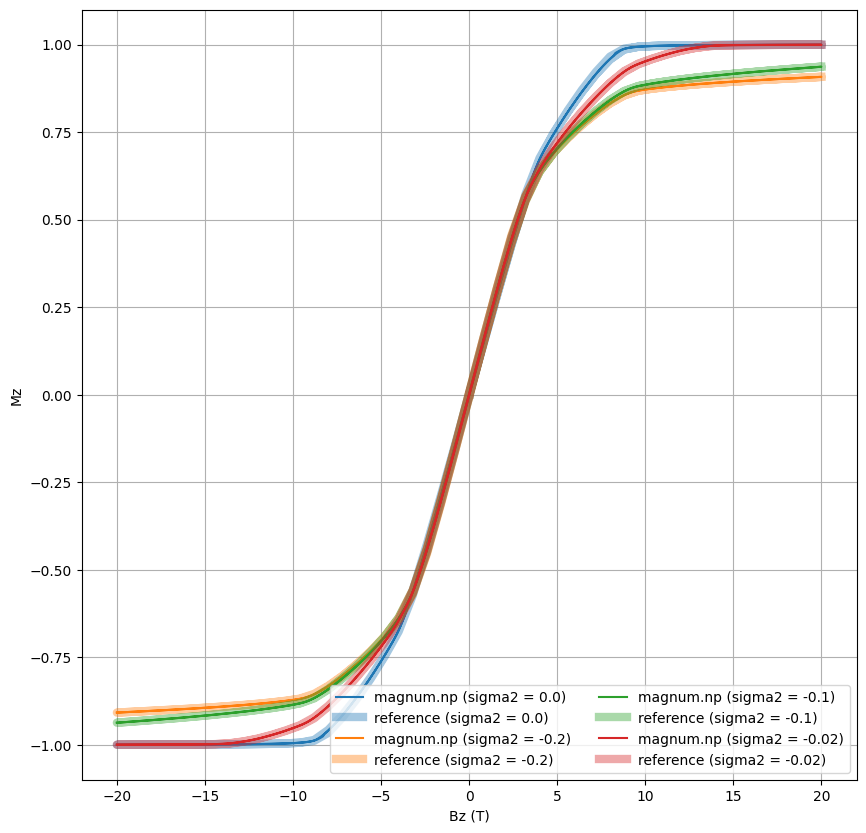

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(figsize=(10, 10))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, sigma in enumerate(np.array([0, -0.1, -0.05, -0.01])):
    ref_Bz = np.load(f"ref/oommf_hysteresis_Bz_sigma2_{sigma}.npy")/1000
    ref_Mz = np.load(f"ref/oommf_hysteresis_mz_sigma2_{sigma}.npy")

    data = np.loadtxt(f"data/m_sigma2_{sigma*2}.dat")
    B = data[:,3]*4*np.pi*1e-7
    M = data[:,9]*2/3 + data[:,12]*1/3

    ax.plot(ref_Bz, ref_Mz, '-', color = cycle[i], label = f"magnum.np (sigma2 = {sigma*2})")
    ax.plot(B, M, '-', color = cycle[i], linewidth = 6, alpha = 0.4, label = f"reference (sigma2 = {sigma * 2})")

ax.set_xlabel("Bz (T)")
ax.set_ylabel("Mz")
ax.legend(ncol = 2)
ax.grid()
fig.savefig("data/results.png", dpi=300)